In [1]:
import geopandas as gpd
import pandas as pd
import requests
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
from shapely.geometry import LineString, Point

In [2]:
jaipur_region = gpd.read_file("data/jaipur_district_adm2.geojson", driver="geojson")  
jaipur_region.to_crs(epsg=4326, inplace=True) 
jaipur_boundary = jaipur_region.geometry.values[0].exterior.coords[:]
polygon_string = " ".join([f"{lat} {lon}" for lon, lat in jaipur_boundary])
polygon_string # polygon string as boundary for overpass query

'26.469111999359935 75.14878800267167 26.473824999360954 75.14514200267155 26.479772999362478 75.14702600267236 26.482100567363194 75.14895017167291 26.48571599936413 75.15193900267366 26.49019999936526 75.15282400267418 26.493577098366128 75.15285546167458 26.500075999367684 75.1529160026751 26.503947999368208 75.1408460026736 26.51296001937008 75.12935199767267 26.52347899937215 75.11593600267149 26.52734217037323 75.1184264256723 26.533277999374796 75.12225300267335 26.54016099937655 75.12385600267422 26.541997598377066 75.12377329067441 26.546777999378182 75.12355800267476 26.55174999937912 75.11476900267381 26.555884999379778 75.10433200267255 26.55497199937935 75.09799200267149 26.548490999377176 75.08177200266833 26.542954999375677 75.07734700266714 26.543437635375764 75.07443483966678 26.54395899937574 75.07128900266625 26.553905219378 75.06367464766596 26.555837999378394 75.06219500266583 26.565196999380838 75.06604000266728 26.573308999382903 75.06768000266824 26.582211999385

In [ ]:
# Build the Overpass  query FOR bus stops and stations
overpass_url = "http://overpass-api.de/api/interpreter"
overpass_query = f"""
[out:json];
(
  // Get stops/stations
  node["highway"="bus_stop"](poly:"{polygon_string}");
  node["railway"="station"](poly:"{polygon_string}");
  node["railway"="subway_entrance"](poly:"{polygon_string}");

);
out body;
>;
out skel qt;
"""

# Make the API call
response = requests.post(overpass_url, data={'data': overpass_query}) # Send the POST request
data = response.json() # Parse response as JSON

STATION / STOPS

In [4]:
nodes_bus = []
nodes_train = []
nodes_metro = []
for el in data['elements']:
  if 'tags' not in el:
    continue
  if el['type'] == 'node':
    if el['tags'].get('highway') == 'bus_stop':
      nodes_bus.append(el)
    elif el['tags'].get('railway') == 'station':
      if el['tags'].get('train') == 'yes' or el['tags'].get('station') == 'train':
        nodes_train.append(el)
      elif el['tags'].get('subway') == 'yes':
        nodes_metro.append(el)
      
print(f"Found {len(nodes_bus)} bus stops, {len(nodes_train)} train stations, and {len(nodes_metro)} metro stations.")

Found 400 bus stops, 46 train stations, and 11 metro stations.


In [5]:
def get_gdfstop_from_el(relation):
  df = pd.json_normalize(relation, sep='_')
  df = df.rename(columns=lambda x: x.replace('tags_', ''))
  geometry = [Point(xy)for xy in zip(df['lon'], df['lat'])]
  gdf = gpd.GeoDataFrame(df, geometry=geometry, crs="EPSG:4326")
  gdf = gdf.dropna(axis=1, how='all')
  gdf = gdf[['name', 'geometry']]
  return gdf

In [6]:
gdf_bus_stops = get_gdfstop_from_el(nodes_bus)
gdf_bus_stops.head()

,name,geometry
0,Ghat ki guni,POINT (75.86123 26.89480)
1,Ramgarh Mod,POINT (75.83951 26.94410)
2,Harmada,POINT (75.76933 27.01505)
3,Theekariya Mod,POINT (75.63315 26.84876)
4,Kalyan Nagar,POINT (75.79430 26.82628)


In [7]:
gdf_train_stations = get_gdfstop_from_el(nodes_train)
gdf_train_stations = gdf_train_stations[gdf_train_stations['name'].notna()]
gdf_train_stations.head()

,name,geometry
0,Getor Jagatpura,POINT (75.83202 26.83700)
1,Dahar-Ka-Balaji,POINT (75.76611 26.94451)
2,Govindgarh Malikpur,POINT (75.64619 27.24036)
3,Banskho,POINT (76.16842 26.85731)
4,Peeplee Ka Bas,POINT (75.26892 26.91064)


In [8]:
gdf_metro_stations = get_gdfstop_from_el(nodes_metro)
gdf_metro_stations = gdf_metro_stations[gdf_metro_stations['name'] != 'Ambabadi Metro (u/c)']
gdf_metro_stations

,name,geometry
1,Sindhi Camp,POINT (75.79982 26.92268)
2,Railway Station,POINT (75.79013 26.91811)
3,Civil Lines,POINT (75.78125 26.90968)
4,Chandpole,POINT (75.80789 26.92660)
5,Choti Chaupar,POINT (75.81846 26.92473)
6,Badi Chaupar,POINT (75.82682 26.92296)
7,Manasarovar,POINT (75.75024 26.87944)
8,Shyam Nagar,POINT (75.77063 26.89648)
9,Vivek Vihar,POINT (75.76841 26.88845)
10,New Aatish Market,POINT (75.76447 26.88015)


In [9]:
# COnvert to Geojson
gdf_bus_stops.to_file("../../public/data/mapMain/bus_stops.geojson", driver='GeoJSON')
gdf_train_stations.to_file("../../public/data/mapMain/train_stations.geojson", driver='GeoJSON')
gdf_metro_stations.to_file("../../public/data/mapMain/metro_stations.geojson", driver='GeoJSON')

CLEANUP (BUS STOPS)

<Axes: >

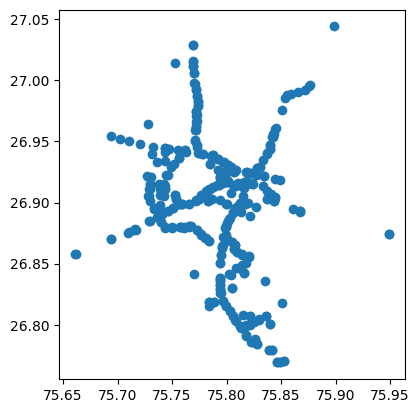

In [27]:
gdf_point = gpd.read_parquet("data/northern-zone-points.geoparquet")
gdf_bus_stops = gdf_point[gdf_point.highway == "bus_stop"]
gdf_bus_stops.to_file("../../public/data/mapMain/bus_stops.geojson", driver='GeoJSON')
gdf_bus_stops.plot()

CLEANUP (metro)

In [ ]:
gdf_polygon = gpd.read_parquet("data/northern-zone-multipolygons.geoparquet")
# Filter for Ram Nagar metro station only
gdf_metro = gdf_polygon[gdf_polygon.name=="Ram Nagar"]
gdf_metro.to_crs(epsg=32645, inplace=True)  
gdf_metro['geometry'] = gdf_metro.geometry.centroid
gdf_metro.to_crs(epsg=4326, inplace=True)
gdf_metro = gdf_metro[['name', 'geometry']]
# add to gdf_metro_stations using concat
gdf_metro_stations = pd.concat([gdf_metro_stations, gdf_metro], ignore_index=True)
gdf_metro_stations.reset_index(drop=True, inplace=True)
# Save the metro stations to GeoJSON
gdf_metro_stations.to_file("../../public/data/mapMain/metro_stations.geojson", driver='GeoJSON')

C:\Users\shaun\AppData\Roaming\Python\Python312\site-packages\geopandas\geodataframe.py:1525: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
